# How PyMoosh works -- illustrated

## How to define the structure

In PyMoosh, you must first define the structure you want to study (a multilayer), which means defining:

- The list of the different materials which compose the structure
- The type of material for each layer
- The thickness (a priori in nanometers)

In PyMoosh, `Structure()` is a class which contains all these informations, making it simple to pass it to different functions.

### Defining materials used

Here comes an example of a list where the first is air/vacuum with a permittivity of 1., the second has a 2 permittivity and 1.2 permeability, the third is gold and the last one water:


In [21]:
# Print existing materials in the pymoosh database excluding CUSTOM material
# print(f"Existing materials {[mat.name for mat in MaterialEnum if mat!=MaterialEnum.CUSTOM]}")
# Define materials list
material_list = [1.,[2.,1.2],"Gold","Water"]

The logic for material properties is the following:
- If you give only one number (real or complex), it is assumed to be the material's permittivity
- If you give an array of two numbers (real or complex), they are assumed to be \[permittivity, permeability\]
- If you give a string, the programm will later check if it is available in the database, and tell you otherwise
- If you give a function, it is assumed it gives the permittivity as a function of the wavelength in nanometers

### How the different materials are stacked

Now you have to define how the different materials you have declared must be stacked. It requires for you to remember where each material is placed in the list above. This could be a source of error, but allows not to compute unnecessarily the permittivy of dispersive materials.

>The first layer is the layer on top (superstrate), then the layer below and so on. Light is assumed to come from the top in PyMoosh.

If you want the light to come from air, then meet glass, water and glass again (the substrate),given the previous material definitions, your list should look like this :

In [22]:
stack = [0,2,3,2]

### Thickness of the different layers

All lengths are assumed to be in nanometers. The thicknesses are stored into a list. 

> The first element is the thickness of the superstrate, which makes no sense, as the superstrate is infinite and truly considered as infinite physically. This thickness intervenes only when the field is visualized. It is the same with the substrate. You can put these to zero if you have no intention of computing the field but are only interested in the reflection/transmission coefficients.

The list could look like that:




In [23]:
thickness = [300, 200, 500, 200]

The structure we imagined so far has an air superstrate, 200 nm of glass, 500 nm of water and a glass substrate.

### Creating an instance of `Structure()`

Now let's get real. We will create a objet belonging to the class `Structure`, using the above defined elements.



In [24]:
from PyMoosh import *
import PyMoosh as pm
print("PyMoosh version: ", pm.__version__)

thing=Structure(material_list, stack, thickness)

PyMoosh version:  3.94
List of materials:
Simple, non dispersive: epsilon= (1+0j)
Magnetic, non dispersive: epsilon= 2.0  mu= 1.2
Database material: BrendelBormann model: Gold
Database material: ExpData: Water


Just in case this would be useful, once the structure has been declared, it contains the list of materials, which contains only objects that are materials and it is possible to access their constitutive parameters quite easily:

In [25]:
gold = thing.materials[2]
water = thing.materials[3]

refractive_index_glass = np.sqrt(gold.get_permittivity(600))
epsilon = water.get_permittivity(600)
# You need to specify a wavelength at which to compute the permittivity, here 600 nm

print(np.sqrt(epsilon))

(1.3336432680149413+0j)


## A single interface as full running example

Let us define a structure corresponding to a single interface between two materials. The above material is air, the substrate is a dielectric with a refractive index of 1.5 and thus a permittivity of $2.25 =1.5^2$.



In [26]:
wavelength = 600
interface = Structure([1.,2.25],[0, 1],[10*wavelength, 10*wavelength])

List of materials:
Simple, non dispersive: epsilon= (1+0j)
Simple, non dispersive: epsilon= (2.25+0j)


### Function `coefficient`

Now we can use the function `coefficient` which provides us with the reflection and transmission coefficients (amplitude and energy) of a multilayer. You need to provide :

- A structure (the object)
- The wavelength (in nm)
- The incidence angle (**in radian** !)
- The polarization : 0 is for TE, 1 (or anything else, in fact) is for TM.

For a single interface in normal incidence, the Fresnel coefficient (amplitude) is supposed to be 0.2 (and 0.04 in energy). Let's see !

In [27]:
# Incidence angle
angle_inc = 0.
# Polarization
pol = 1.
[r,t,R,T] = coefficient(interface,wavelength,angle_inc,pol)

print('Fresnel coefficient')
print(r)
print('Reflectance')
print(R)

Fresnel coefficient
(0.20000000000000007+0j)
Reflectance
0.04000000000000003


### Function `angular`

In order to get the reflectance as a function of the angle of incidence more easily, the function `angular` requires: 

- a structure,
- the wavelength,
- the polarization (0 or 1, as above)
- the beginning of the incidence angle range (**in degrees**)
- the end of the incidence angle range (**in degrees**)
- the number of different incidence angle

And then you can plot and see the difference between the two polarization. If ever you speak french, you can check [this video](https://youtu.be/5L1mFYTntGk) for more on polarization.


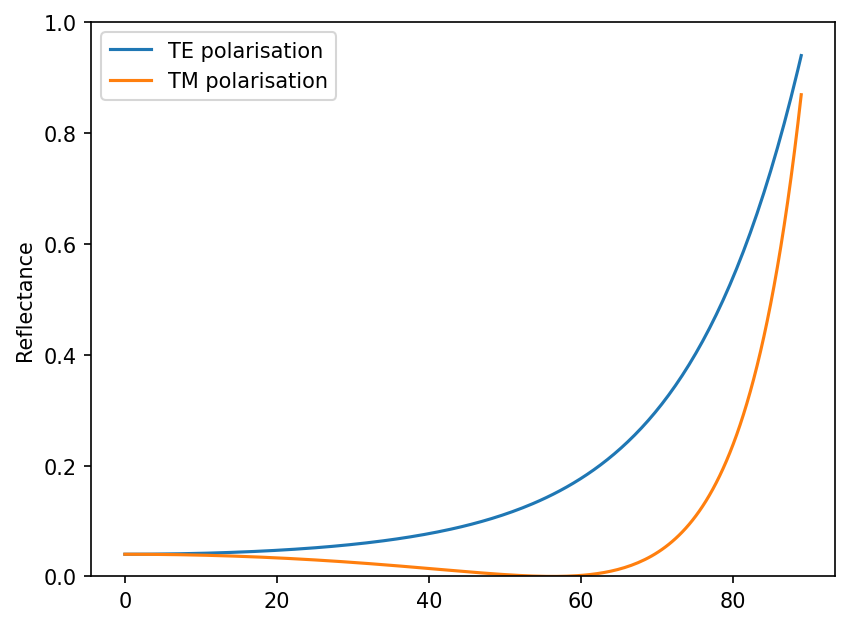

In [28]:
# For TE polarization
incidence, r, t, R, T = angular(interface, wavelength, 0., 0., 89., 200)
# For TM polarization, same incidence angles
incidence, r_p, t_p, R_p, T_p = angular(interface, wavelength, 1., 0., 89., 200)

# Visualization of the result
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

plt.figure(1)
plt.plot(incidence, R, label="TE polarisation")
plt.plot(incidence, R_p, label="TM polarisation")
plt.ylabel('Reflectance')
plt.ylim(0,1)
plt.legend()
plt.show()


### More controlled angles: Function `angular_list`

You can choose at which angles you compute the reflectance, using the function `angular_list`, which requires: 

- a structure,
- the wavelength,
- the polarization (0 or 1, as above)
- the incidence angle range (**in degrees**)


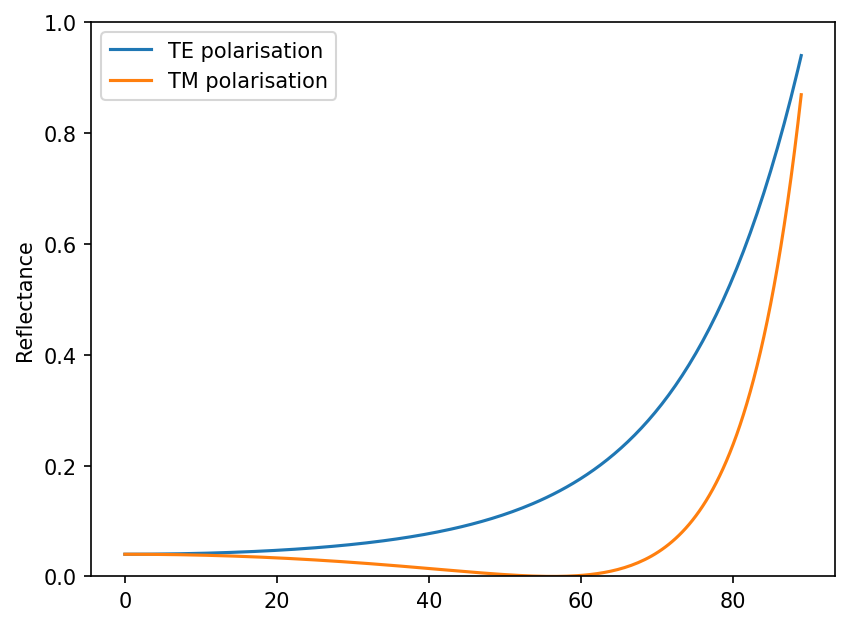

In [ ]:
angles = np.linspace(2, 64, 50)
# For TE polarization
r2, t2, R2, T2 = angular(interface, wavelength, 0., angles)
# For TM polarization, same incidence angles
r2_p, t2_p, R2_p, T2_p = angular(interface, wavelength, 1., angles)

# Visualization of the result
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

plt.figure(1)
plt.plot(angles, R2, label="TE polarisation")
plt.plot(angles, R2_p, label="TM polarisation")
plt.ylabel('Reflectance')
plt.ylim(0,1)
plt.legend()
plt.show()


### Function `spectrum`

In order to get the reflectance as a function of the wavelength more easily, the function `spectrum` requires: 

- a structure,
- the angle of incidence,
- the polarization (0 or 1, as above)
- the beginning of the spectral range (**in nm**)
- the end of the spectral range (**in nm**)
- the number of different wavelengths

And then you can plot and see the difference between the two polarization. If ever you speak french, you can check [this video](https://youtu.be/5L1mFYTntGk) for more on polarization.


List of materials:
Simple, non dispersive: epsilon= (1+0j)
Database material: BrendelBormann model: Gold


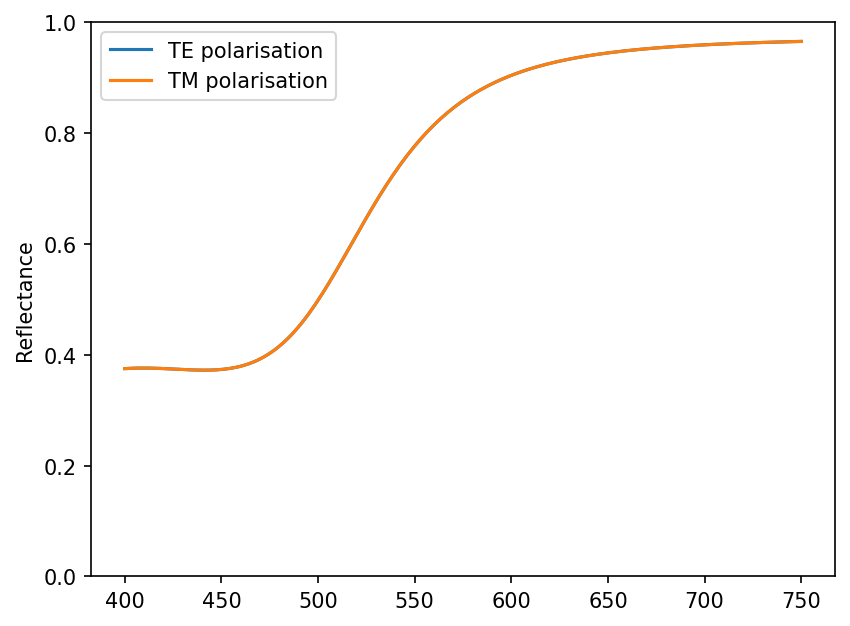

In [ ]:

interface2 = Structure([1.,"Gold"],[0, 1],[10*wavelength, 10*wavelength])

# For TE polarization
wavelengths, r, t, R2, T = spectrum(interface2, 0., 0., 400, 750., 200)
# For TM polarization, same incidence angles
wavelengths, r_p, t_p, R_p2, T_p = spectrum(interface2, 0., 1., 400, 750., 200)

# Visualization of the result
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

plt.figure(1)
plt.plot(wavelengths, R2, label="TE polarisation")
plt.plot(wavelengths, R_p2, label="TM polarisation")
plt.ylabel('Reflectance')
plt.ylim(0,1)
plt.legend()
plt.show()


### More controlled spectrum : `spectrum_list`

Because it is not always convenient to use a linear range of wavelenghts, you may want to define your own wavelength list. For this, use the function `spectrum_list`, which requires: 

- a structure,
- the incidence angle,
- the polarization (0 or 1, as above)
- the wavelength list (**in nm**)


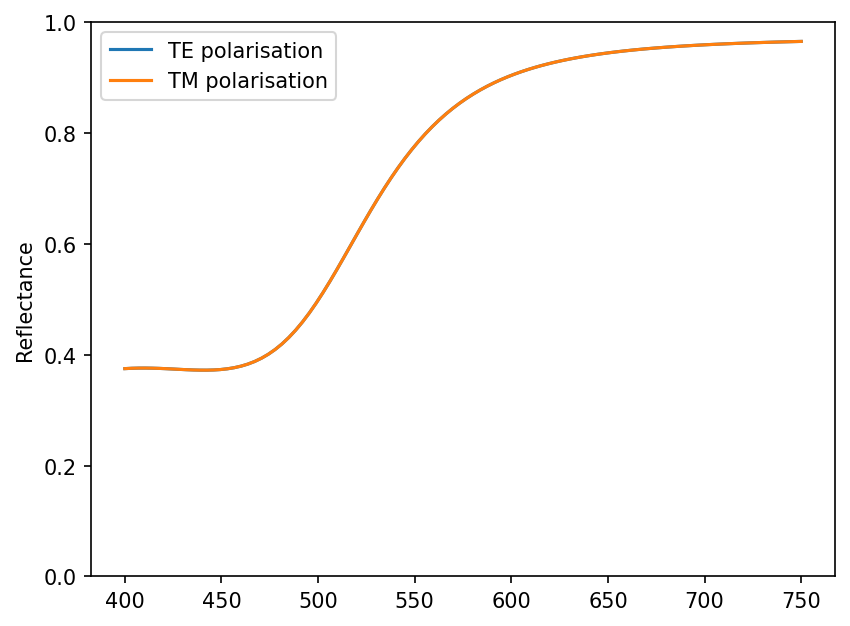

In [30]:
wavelengths = np.linspace(400, 750, 100)
# For TE polarization
r, t, R2, T = spectrum_list(interface2, 0., 0., wavelengths)
# For TM polarization, same incidence angles
r_p, t_p, R_p2, T_p = spectrum_list(interface2, 0., 1., wavelengths)

# Visualization of the result
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

plt.figure(1)
plt.plot(wavelengths, R2, label="TE polarisation")
plt.plot(wavelengths, R_p2, label="TM polarisation")
plt.ylabel('Reflectance')
plt.ylim(0,1)
plt.legend()
plt.show()

### A map of the field

First you have to define your "observation window" and there is a class `Window` for that. Essentially you need to specify : 

- The horizontal width of the window (in nm)
- Where you put the incident beam with respect to the window (or the other way around, which is why this parameter is in the object Window). The value 0 corresponds to the middle of the incident beam completely on the left, 1 means completely on the right, and 0.5 just in the middle.
- The horizontal size of a single pixel of the field map (real number, in nm)
- The vertical size of a single pixel (real number, in nm)

For a window of 70 wavelength, with a beam quite at 70% of the window, and square pixels 30 nm wide, this gives:

In [31]:
window = Window(70*wavelength, 0.7, 30., 30.)


Pixels horizontally: 1400


Now you need to define your incident beam by providing:

- The wavelength in vacuum, of course (the frequency, in reality)
- The angle of incidence (**in radian**)
- The polarization (0 or 1, as above)
- The beam typical width (the waist, in nm)

For a 10 wavelength wide beam, with a 45° incidence angle ($\pi/4$ radian) in TE polarization:


In [32]:
import numpy as np

beam = Beam(wavelength, np.pi/4, 0, 10*wavelength)


Incidence in degrees: 45.0
E//, TE, s polarization


Now you can call `field` to which you should provide three objects: the structure, the beam and the window...

Pixels vertically: 400


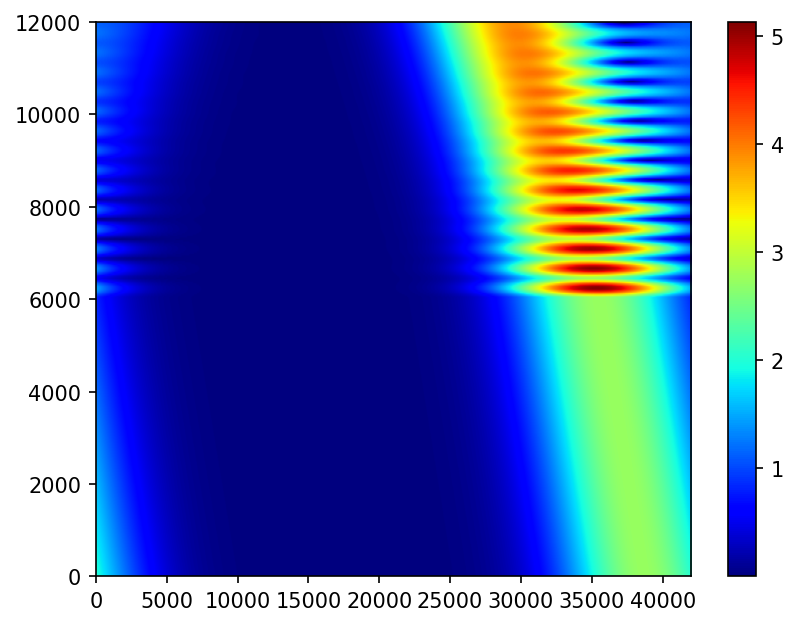

In [33]:
E = field(interface,beam,window)

plt.figure(2)
plt.imshow(abs(E),cmap='jet',extent=[0,window.width,0,sum(interface.thickness)],aspect='auto')
plt.colorbar()

> As you can see, the simulation domain is periodic: if something goes out on the right, it comes in on the left. 

We can directly modify the object Window to change the centering of the beam and the thickness of the substrate represented, making things clearer:


Pixels vertically: 600


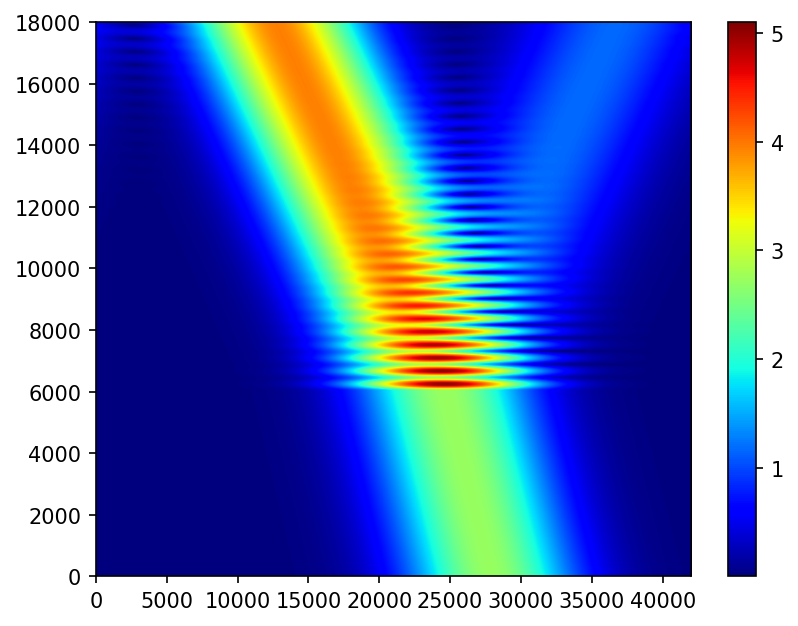

In [34]:
beam.polarization = 0
window.C = 0.3
interface.thickness[0] = 20*wavelength
E = field(interface, beam, window)

plt.figure(2)
plt.imshow(abs(E), cmap='jet',extent=[0, window.width, 0,sum(interface.thickness)], aspect='auto')
plt.colorbar()

Now the incident beam can be seen, as well as the reflected one and the interferences between the two. Representing the real part of the field instead of its modulus allows to visualize the wavefronts. We do that by representing only the positive values of the real part to make things prettier (it's just a matter of aesthetics). 

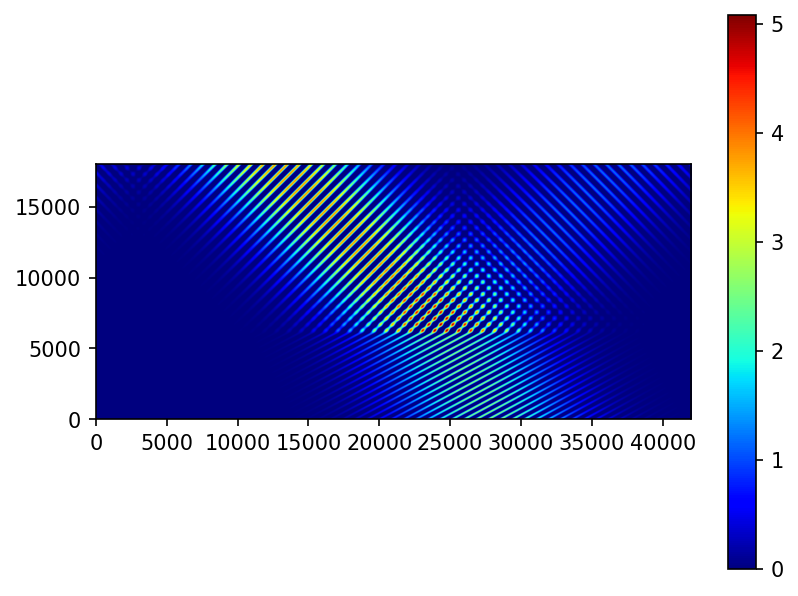

In [35]:
F = np.real(E)

plt.imshow(F*(F>0), cmap='jet',extent=[0, window.width,0, sum(interface.thickness)])
plt.colorbar()
plt.show()

## Brewster angle



The Brewster angle is the angle for which the reflection coefficient corresponding to the $p$ polarization vanishes. We have the following analytic expression 
$$\theta_B = \arctan \frac{n_2}{n_1} \simeq 56.31°$$
and we can check on the reflectance that, indeed, one of the polarization vanishes. 

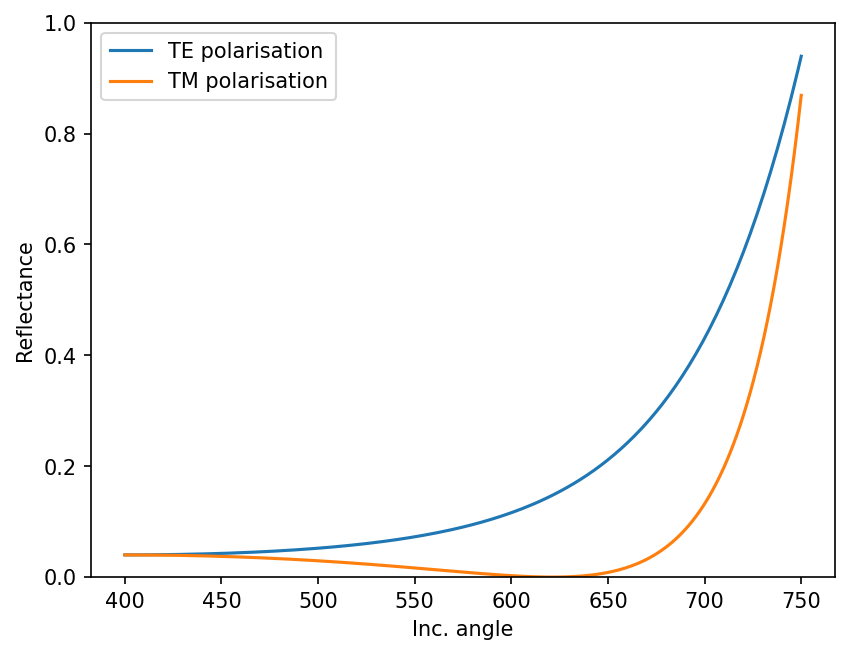

In [36]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(incidence,R, label="TE polarisation")
plt.plot(incidence,R_p, label="TM polarisation")
plt.xlabel("Inc. angle")
plt.ylabel('Reflectance')
plt.ylim(0,1)
plt.legend()
plt.show()


It it then possible to map the corresponding field, to see that no wave is reflected here :

Pixels vertically: 600


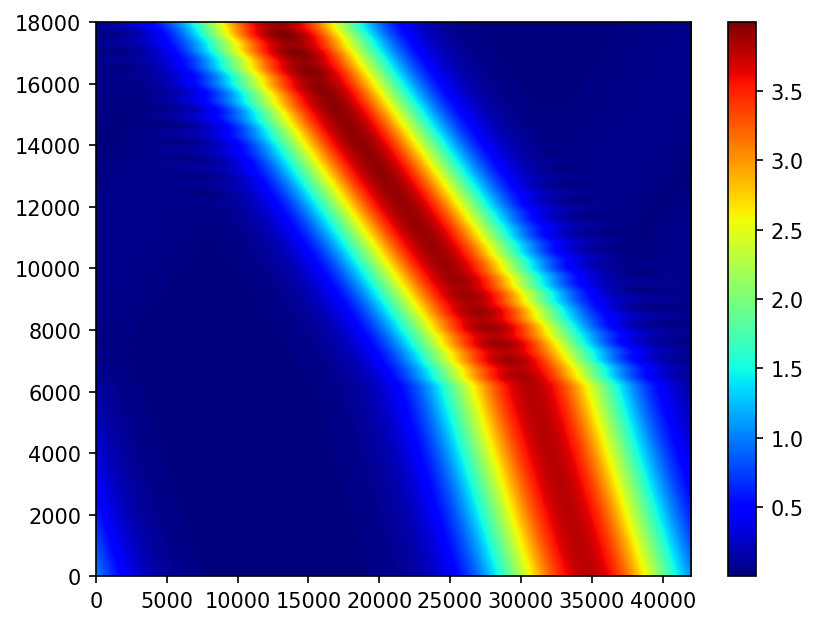

In [37]:
beam.polarization = 1
beam.incidence = 56.31*np.pi/180.
E = field(interface, beam, window)

plt.figure(2)
plt.imshow(abs(E), cmap='jet',extent=[ 0, window.width, 0, sum(interface.thickness)], aspect='auto')
plt.colorbar()